In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cmcrameri import cm as  cmc
import matplotlib as mpl
import pandas as pd
import xarray as xr
import itertools
import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')

import ml_estimation as ml
import model1_plots as mp
import model2_plots as mp2
import model1_explore as me
import model1 as mod1
from scipy.stats import norm, beta
from statsmodels.base.model import GenericLikelihoodModel
import palettable as pal

import Utilities as util


In [2]:
loc_model = '../mod/model2/'
loc_fig = '../fig/model2/'

dh = 200
dd = .2
dH = 500 
dD = .5
N = 5000

prop = {'dH' : dH, 'dD' : dD, 'N' : N }
prop = '_'.join([f'{x}={prop[x]}' for x in prop]).replace('.' ,'_')
loc_model = loc_model + prop

# read data
# explorative
# 0. overview
ds_c = xr.open_dataset(loc_model + 'expl_hist_clouds.nc')
ds_cN = xr.open_dataset(loc_model + 'expl_hist_cloudN.nc')
T_total = pd.read_csv(loc_model + 'expl_transition_ctypes.csv', index_col = 0)



# 1. cs -> cs

# 2. c -> cs
ds = xr.open_dataset(loc_model + 'expl_local_param.nc')


# global model1
# df_glob_c_to_c_cod = pd.read_csv(loc_model + 'glob_c_to_c_cod.csv')
# ds_theta = xr.open_dataset(loc_model + 'glob_theta.nc')




In [3]:
ds


<xarray.Dataset>
Dimensions:          (bin_edges: 51, cs_mu_dN: 5, cs_mu_hN: 5, d_next: 50, est: 2, h_next: 50, method: 2, mu_csf: 3, mu_d: 3, mu_dN: 5, mu_h: 3, mu_hN: 5, var_cod: 2, var_cth_b: 2, var_cth_bm: 5)
Coordinates:
  * mu_h             (mu_h) int64 1000 7000 13000
  * mu_d             (mu_d) float64 -0.5 1.5 3.5
  * mu_hN            (mu_hN) int64 -1500 -750 0 750 1500
  * mu_dN            (mu_dN) float64 -0.8 -0.4 0.0 0.4 0.8
  * cs_mu_hN         (cs_mu_hN) int64 1000 4000 7000 10000 13000
  * cs_mu_dN         (cs_mu_dN) float64 -0.5 0.5 1.5 2.5 3.5
  * mu_csf           (mu_csf) float64 0.2 0.5 0.8
  * method           (method) object 'ML' 'MoM'
  * est              (est) object 'coef' 'bse'
  * var_cth_bm       (var_cth_bm) object 'mu1' 'nu1' 'mu2' 'mu2' 'p'
  * var_cod          (var_cod) object 'mu' 'sigma'
  * var_cth_b        (var_cth_b) object 'alpha' 'beta'
Dimensions without coordinates: bin_edges, d_next, h_next
Data variables: (12/16)
    n                (mu_h, mu_d, mu_hN, mu_dN, mu_csf) float64 ...
    p_cs             (mu_h, mu_d, mu_hN, mu_dN, mu_csf) float64 ...
    freq             (mu_h, mu_d, mu_hN, mu_dN, mu_csf, h_next, d_next) float64 ...
    hedges           (mu_h, mu_d, mu_hN, mu_dN, mu_csf, bin_edges) float64 ...
    dedges           (mu_h, mu_d, mu_hN, mu_dN, mu_csf, bin_edges) float64 ...
    param_cod        (mu_h, mu_d, mu_hN, mu_dN, mu_csf, var_cod) float64 ...
    ...               ...
    cs_freq          (cs_mu_hN, cs_mu_dN, mu_csf, h_next, d_next) float64 ...
    cs_hedges        (cs_mu_hN, cs_mu_dN, mu_csf, bin_edges) float64 ...
    cs_dedges        (cs_mu_hN, cs_mu_dN, mu_csf, bin_edges) float64 ...
    cs_param_cod     (cs_mu_hN, cs_mu_dN, mu_csf, var_cod) float64 ...
    cs_param_cth_bm  (cs_mu_hN, cs_mu_dN, mu_csf, est, var_cth_bm) float64 ...
    cs_param_cth_b   (cs_mu_hN, cs_mu_dN, mu_csf, est, method, var_cth_b) float64 ...

## 0. Cloud distribution

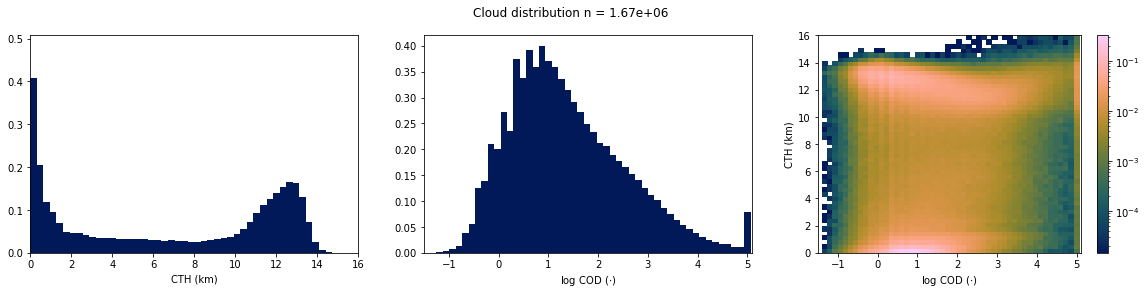

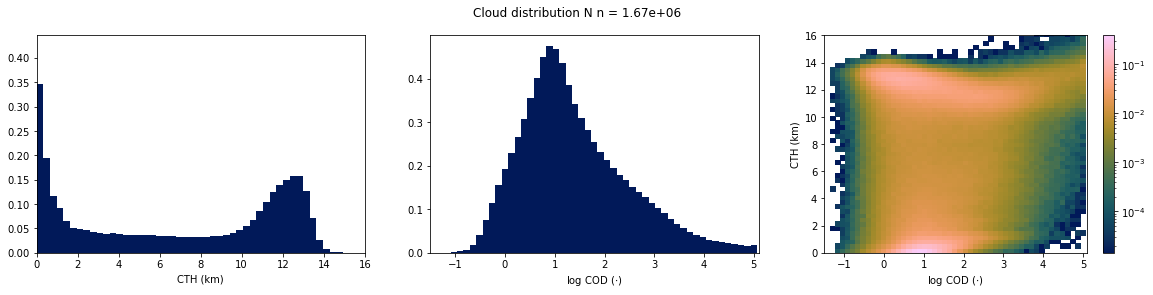

In [4]:
from palettable.cubehelix import Cubehelix
palette = Cubehelix.make(start=1, rotation=2, n=16)

dedges, hedges, freq = ds_c.dedges.data, ds_c.hedges.data, ds_c.freq.data
fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution n = {freq.sum().sum():.2e}',
                          density = True,
#                             cmap = pal.cubehelix.perceptual_rainbow_16.mpl_colormap,
                            cmap = cmc.batlow,
                            )
fig.savefig(loc_fig + 'expl_cloud_distr.png')

dedges, hedges, freq = ds_cN.dedges.data, ds_cN.hedges.data, ds_cN.freq.data
fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution N n = {freq.sum().sum():.2e}',
                          density = True,
#                             cmap = pal.cubehelix.perceptual_rainbow_16.mpl_colormap,
                            cmap = cmc.batlow,
                            )
fig.savefig(loc_fig + 'expl_cloudN_distr.png')



In [5]:
T = T_total#.iloc[:-1]
print(T.index)
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T = T.rename(
            columns = classes, 
             index = classes
            )
T

loc_model1 = '../mod/model1/'
T_total_data = pd.read_csv(loc_model1 + 'expl_transition_ctypes.csv', index_col = 0)
T_data = T_total_data#.iloc[:-1]

print(T_data.index)
# T.columns, T.index = T.columns.astype(int), T.index.astype(int)
classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T_data = T_data.rename(
            columns = classes, 
             index = classes
            ).drop(['invalid pixel'], axis = 1).drop(['invalid pixel'])
T_data.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')

T_diff = (T_data - T)


import seaborn as sns
cmap = sns.light_palette("green", as_cmap=True)



T_diff.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')
# classes
T.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0',
       'All'],
      dtype='object', name='from')
Index(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0',
       '10.0', 'All'],
      dtype='object', name='from')


,clear sky,cumulus,altocumulus,cirrus,stratocumulus,altostratus,cirrostratus,stratus,nimbostratus,deep convection
from,,,,,,,,,,
clear sky,0.79,0.13,0.02,0.02,0.04,0.00,0.00,0.00,0.00,0.00
cumulus,0.18,0.54,0.06,0.03,0.15,0.02,0.00,0.00,0.00,0.00
altocumulus,0.06,0.14,0.39,0.19,0.03,0.15,0.04,0.00,0.01,0.00
cirrus,0.04,0.03,0.07,0.73,0.00,0.01,0.12,0.00,0.00,0.00
stratocumulus,0.11,0.31,0.03,0.01,0.45,0.05,0.01,0.03,0.00,0.00
altostratus,0.01,0.03,0.13,0.04,0.05,0.57,0.09,0.00,0.06,0.01
cirrostratus,0.00,0.00,0.02,0.16,0.00,0.05,0.69,0.00,0.01,0.07
stratus,0.03,0.12,0.01,0.00,0.48,0.06,0.01,0.23,0.05,0.00
nimbostratus,0.00,0.01,0.02,0.01,0.03,0.34,0.06,0.02,0.45,0.07


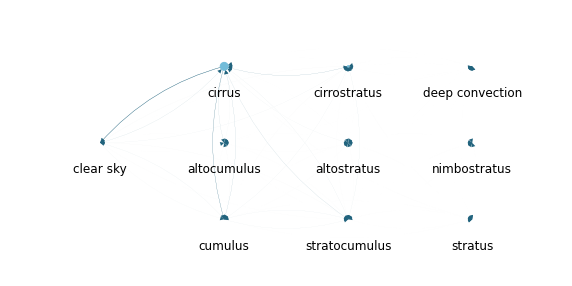

In [6]:
from itertools import combinations_with_replacement
import random
import networkx as nx

random.seed(0)

T = T_diff

node_names = list(util.ISCCP_classes.values())[1:]
G = nx.DiGraph()
G.add_nodes_from(node_names)

for (u, v) in combinations_with_replacement(node_names, 2):
    G.add_edge(u, v, weight = T.loc[u,v])
    G.add_edge(v, u, weight = T.loc[v,u])

# for (u, v, weight) in G.edges.data('weight'):
#     print(f"Edge {u} -> {v} weights {weight}.")
    

pos = {'clear sky': np.array([-1, 1]),
         'cumulus': np.array([ 0, 0]),
         'altocumulus': np.array([0,  1]),
         'cirrus': np.array([0,  2]),
         'stratocumulus': np.array([1, 0 ]),
         'altostratus': np.array([1, 1]),
         'cirrostratus': np.array([1, 2]),
         'stratus': np.array([ 2, 0]),
         'nimbostratus': np.array([2, 1]),
         'deep convection': np.array([2, 2])}

node_size = T.loc['All', node_names] * 5000
edge_widths = [w * T.loc['All',edge[0]] * 1000 for (*edge, w) in G.edges.data('weight')] # weight * node size
labels = {item:item for item in node_names}

fig = plt.figure(figsize = (10, 5))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size = node_size,
        node_color =  '#72BCD9',
#         alpha = 0,
)

nx.draw_networkx_edges(G, pos, width=edge_widths,
                       node_size = node_size,
                       edge_color = '#21637D',
                       connectionstyle='arc3, rad=.15'
 )

pos_labels = {k: v + [0, -.35] for k, v in pos.items()}
nx.draw_networkx_labels(G, pos_labels, font_color = 'black')
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)

plt.savefig(loc_fig + 'graph_diff.png', transparent=True)

In [7]:
# edge_widths = [(w * 10 , print(T.loc['All',edge[0]])) for (*edge, w) in G.edges.data('weight')]


### 0. Number of observations

(<Figure size 1440x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF90C14C0>,
       dtype=object))

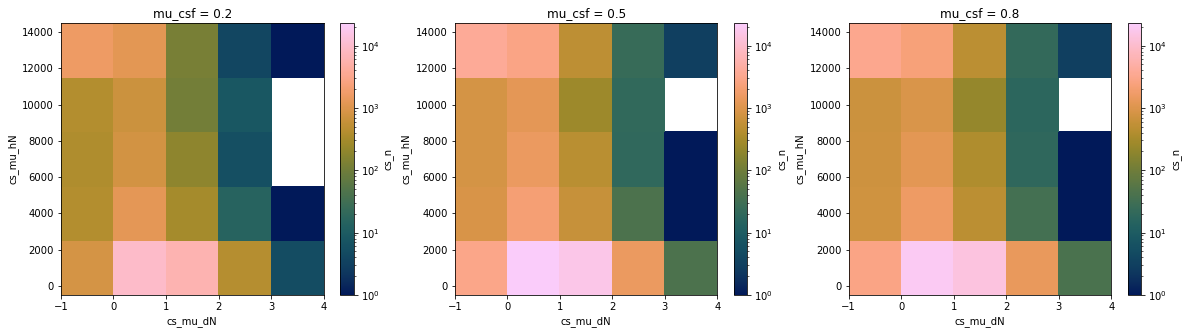

In [6]:
mp2.plotLocalParamfromCS(ds.cs_n.where(ds.cs_n > 0) , norm = mpl.colors.LogNorm())

# 1. Clear sky to Clear sky

(<Figure size 1440x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF9F54A30>,
       dtype=object))

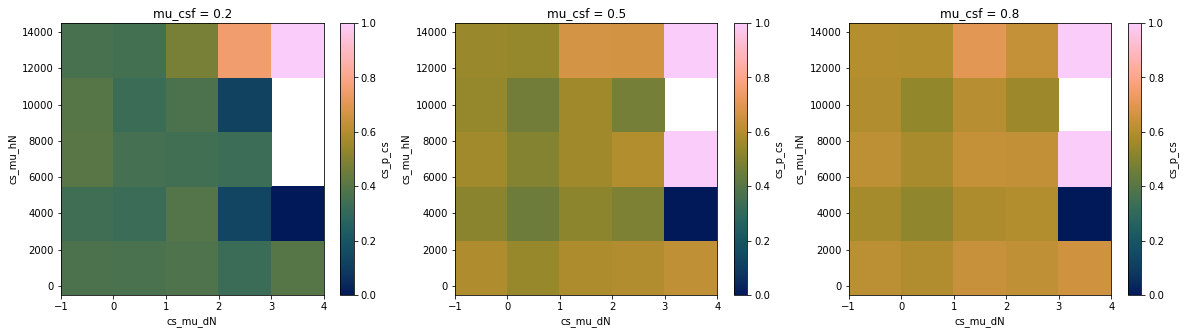

In [7]:
mp2.plotLocalParamfromCS(ds.cs_p_cs)


# 2. Cloud to clear sky

In [4]:
mu_h = ds.mu_h # m
mu_d = ds.mu_d
mu_hN = ds.mu_hN
mu_dN = ds.mu_dN
mu_csf = ds.mu_csf

n_h = len(mu_h)
n_d = len(mu_d)

# ds.p_cs.scatter('mu_h',  'mu_d')
df = ds.p_cs.to_dataframe()
df = df.reset_index()
df
ds.p_cs

<xarray.DataArray 'p_cs' (mu_h: 3, mu_d: 3, mu_hN: 5, mu_dN: 5, mu_csf: 3)>
array([[[[[     nan, ...,      nan],
          ...,
          [     nan, ...,      nan]],

         ...,

         [[0.333333, ..., 1.      ],
          ...,
          [0.121673, ..., 0.529412]]],


        ...,


        [[[     nan, ...,      nan],
          ...,
          [     nan, ...,      nan]],

         ...,

         [[0.014706, ...,      nan],
          ...,
          [0.      , ...,      nan]]]],



       ...,



       [[[[0.444444, ..., 1.      ],
          ...,
          [0.079529, ..., 0.333333]],

         ...,

         [[     nan, ...,      nan],
          ...,
          [     nan, ...,      nan]]],


        ...,


        [[[0.011765, ...,      nan],
          ...,
          [0.      , ...,      nan]],

         ...,

         [[     nan, ...,      nan],
          ...,
          [0.      , ...,      nan]]]]])
Coordinates:
  * mu_h     (mu_h) int64 1000 7000 13000
  * mu_d     (mu_d) float64 -0.5 1.5 3.5
  * mu_hN    (mu_hN) int64 -1500 -750 0 750 1500
  * mu_dN    (mu_dN) float64 -0.8 -0.4 0.0 0.4 0.8
  * mu_csf   (mu_csf) float64 0.2 0.5 0.8

In [11]:
np.arange(3)

array([0, 1, 2])

3

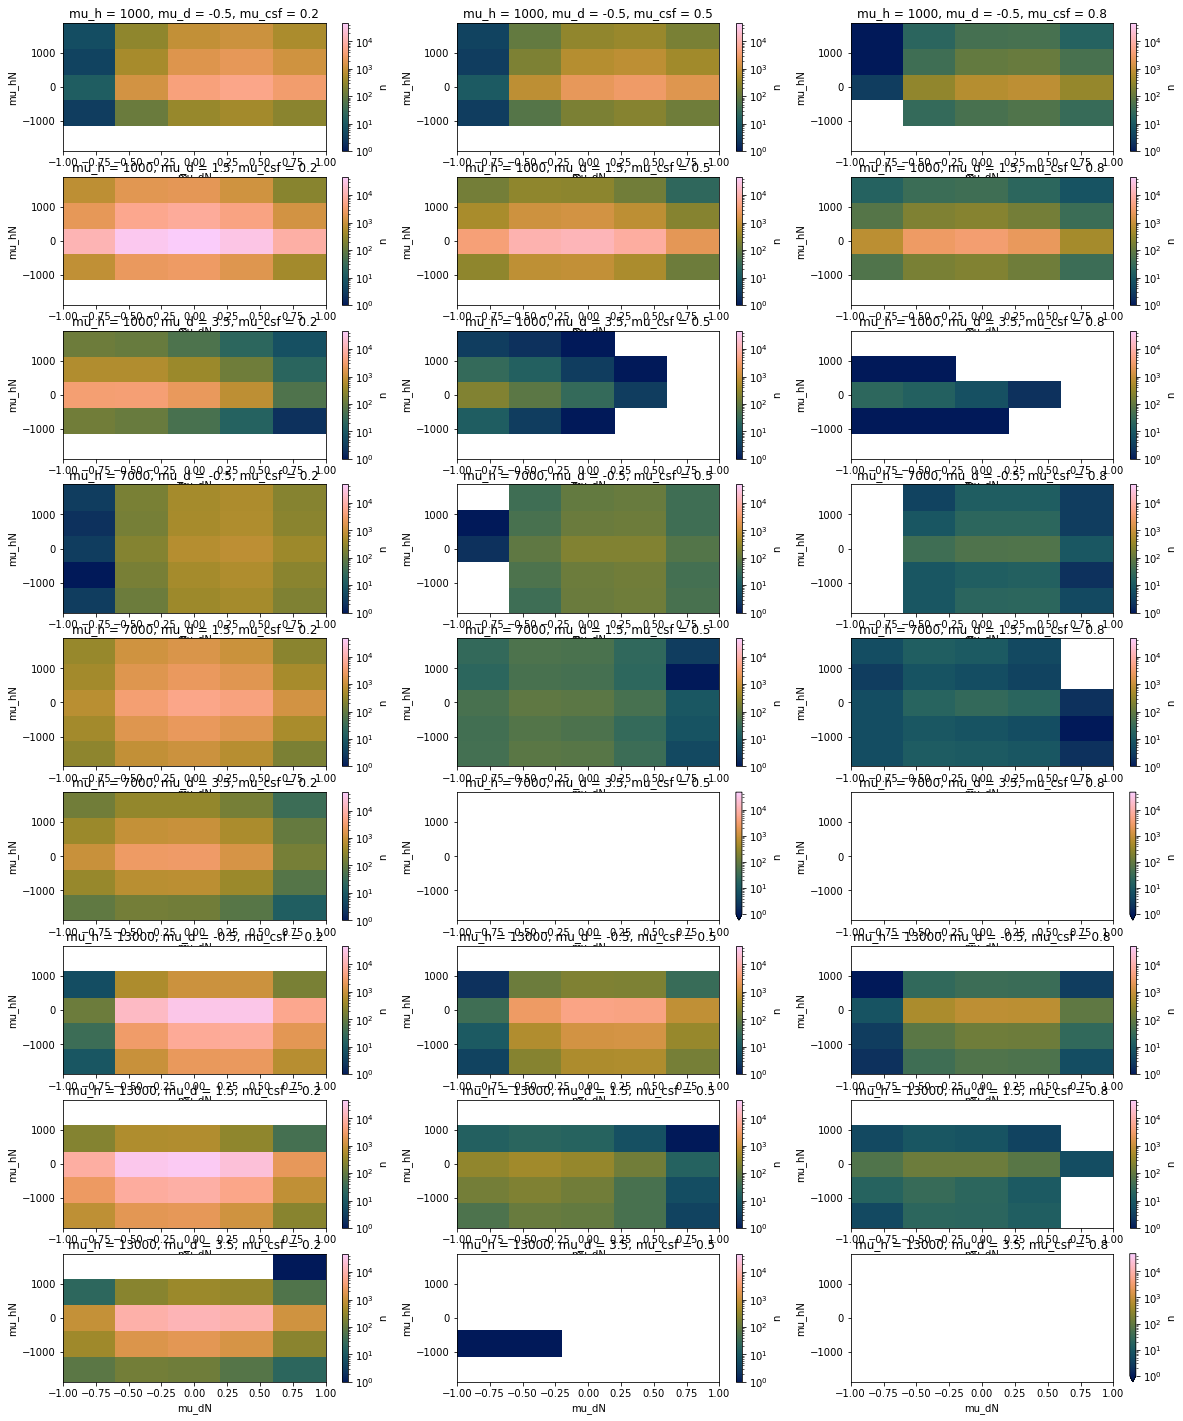

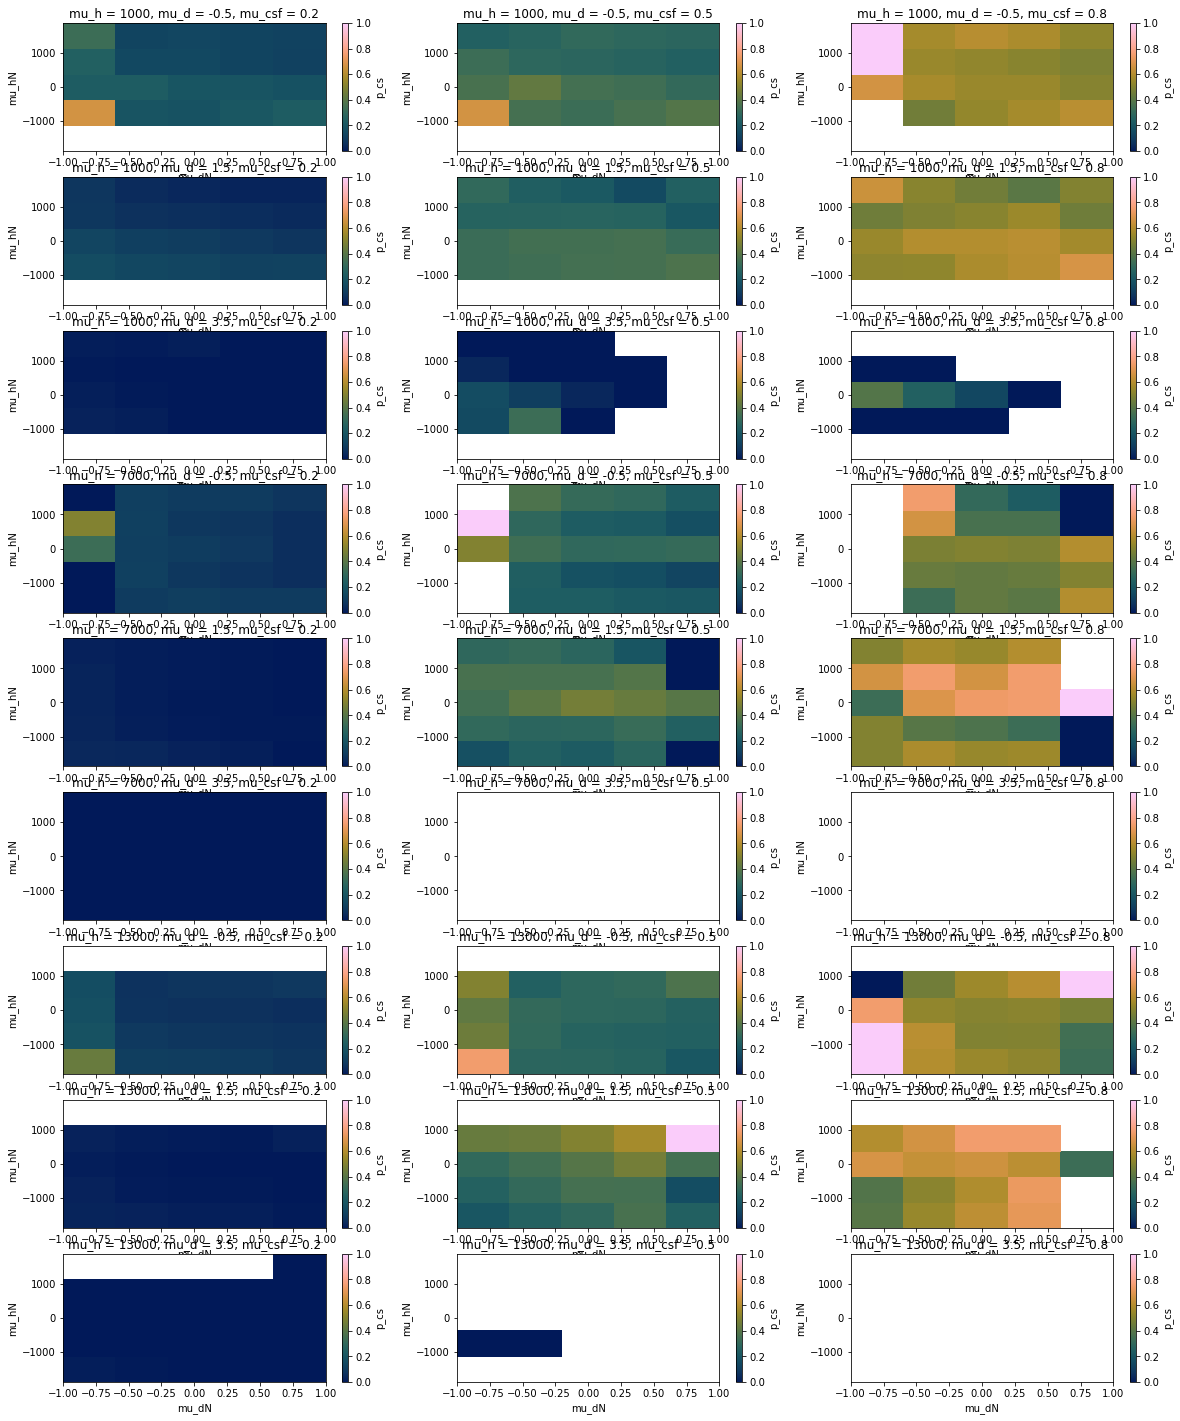

In [12]:
# df.plot.scatter('mu_csf', 'p_cs', c = 'mu_d')
import itertools
# vmin = ds.p_cs.min()
# vmax = ds.p_cs.max()
# fig, ax = plt.subplots(3,3, figsize = (20,15))

# for d, csf in itertools.product(np.arange(len(mu_d)), np.arange(len(mu_csf))):
#     ds.p_cs[0, d, :, :, csf].plot(ax = ax[d, csf], vmin = vmin, vmax = vmax)
def plotLocalParam(theta, 
                   cmap = cmc.batlow,
                   **kwargs):
    vmin = theta.min()
    vmax = theta.max()
    
    mu_d = theta.mu_d
    mu_csf = theta.mu_csf
    mu_h = theta.mu_h
    
    prop = dict( cmap = cmap, vmin = vmin, vmax = vmax, )

    
    fig, ax = plt.subplots(len(mu_d) * len(mu_h),len(mu_csf), figsize = (20,25))
    
    for h, d, csf in itertools.product(np.arange(len(mu_h)),
                                    np.arange(len(mu_d)),
                                    np.arange(len(mu_csf))):
        theta[h, d, :, :, csf].plot(ax = ax[3 * h +  d, csf], **prop, **kwargs)
        
    return fig, ax



plotLocalParam(ds.n.where(ds.n > 0), norm = mpl.colors.LogNorm())

plotLocalParam(ds.p_cs)
3

In [13]:
cond = dict(mu_hN = mu_hN[3].data, mu_dN = mu_dN[1].data, mu_csf = mu_csf[1].data )
cond_str = ', '.join([f'{k} = {cond[k]}' for k in cond])
cond_str

'mu_hN = 750, mu_dN = -0.4, mu_csf = 0.5'

In [26]:
ds.cs_p_cs

<xarray.DataArray 'cs_p_cs' (cs_mu_hN: 5, cs_mu_dN: 5, mu_csf: 3)>
array([[[0.371394, 0.592371, 0.616571],
        [0.369609, 0.544938, 0.595637],
        [0.381553, 0.586003, 0.637128],
        [0.327014, 0.596294, 0.626241],
        [0.4     , 0.627907, 0.658537]],

       [[0.342995, 0.517897, 0.573351],
        [0.326781, 0.453125, 0.529483],
        [0.393082, 0.520458, 0.587629],
        [0.133333, 0.488372, 0.6     ],
        [0.      , 0.      , 0.      ]],

       [[0.405836, 0.564958, 0.62358 ],
        [0.356061, 0.507246, 0.576342],
        [0.34375 , 0.562363, 0.632812],
        [0.333333, 0.6     , 0.631579],
        [     nan, 1.      , 1.      ]],

       [[0.401478, 0.540024, 0.594556],
        [0.331852, 0.461538, 0.536278],
        [0.372727, 0.560606, 0.60793 ],
        [0.125   , 0.47619 , 0.555556],
        [     nan,      nan,      nan]],

       [[0.365794, 0.548264, 0.605088],
        [0.353535, 0.541935, 0.601206],
        [0.479675, 0.670588, 0.704017],
        [0.75    , 0.666667, 0.636364],
        [1.      , 1.      , 1.      ]]])
Coordinates:
  * cs_mu_hN  (cs_mu_hN) int64 1000 4000 7000 10000 13000
  * cs_mu_dN  (cs_mu_dN) float64 -0.5 0.5 1.5 2.5 3.5
  * mu_csf    (mu_csf) float64 0.2 0.5 0.8

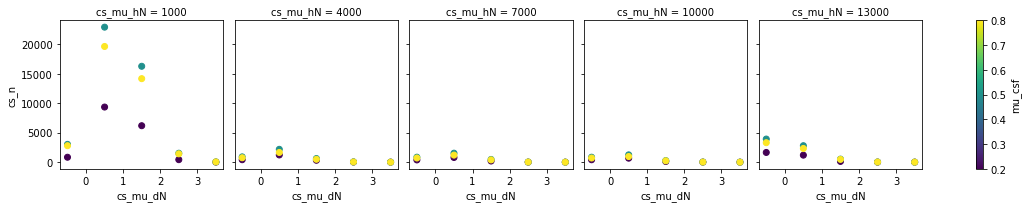

In [40]:
g = ds.plot.scatter(y = 'cs_n', x = 'cs_mu_dN', col = 'cs_mu_hN', hue ='mu_csf')


Influence of conditional parameters on mu1.


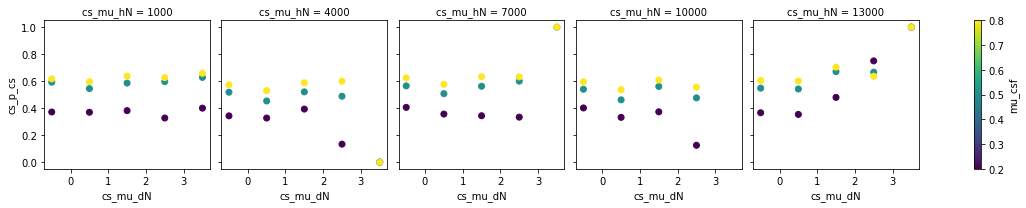

In [35]:
g = ds.plot.scatter(y = 'cs_p_cs', x = 'cs_mu_dN', col = 'cs_mu_hN', hue ='mu_csf')
print('Influence of conditional parameters on mu1.')

Influence of conditional parameters on mu1.


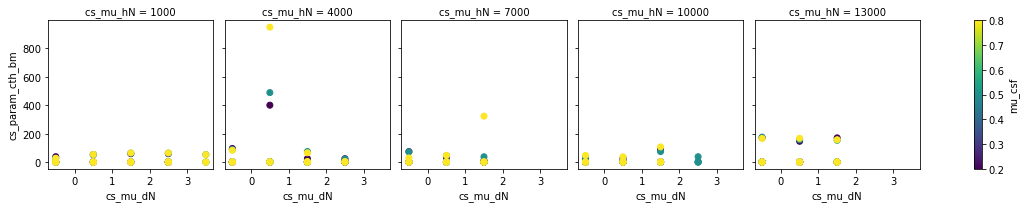

In [39]:
theta = ds.loc[dict(est = 'coef')]
g = theta.plot.scatter(y = 'cs_param_cth_bm', x = 'cs_mu_dN', col = 'cs_mu_hN', hue ='mu_csf')
print('Influence of conditional parameters on mu1.')

Influence of conditional parameters on mu1.


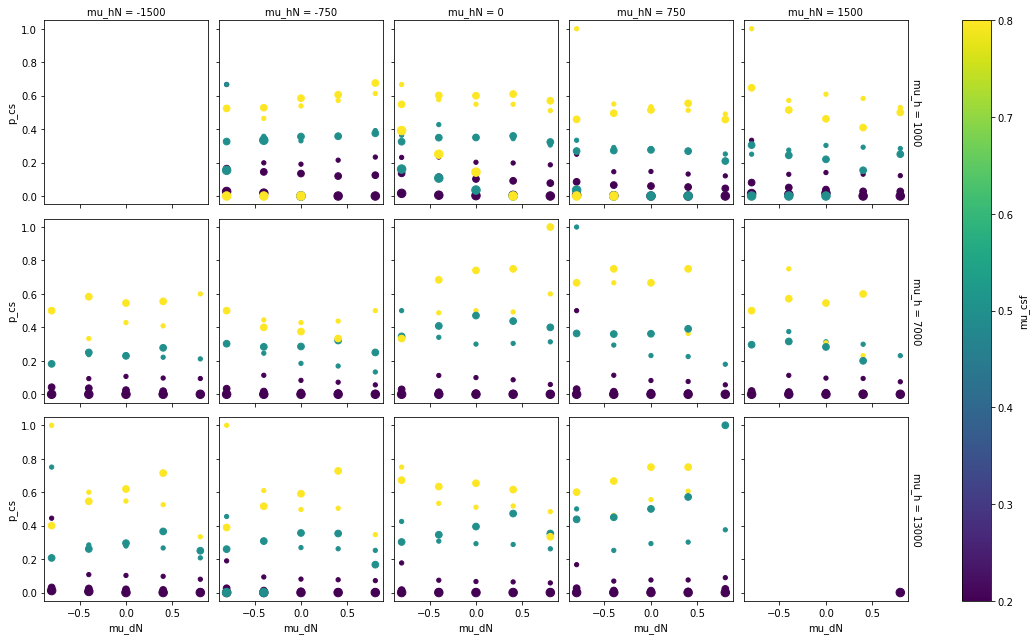

In [36]:
g = ds.plot.scatter(y = 'p_cs', x = 'mu_dN', hue = 'mu_csf', col = 'mu_hN', row = 'mu_h', markersize = 'mu_d')
print('Influence of conditional parameters on mu1.')

# 3. Clear sky to Cloud

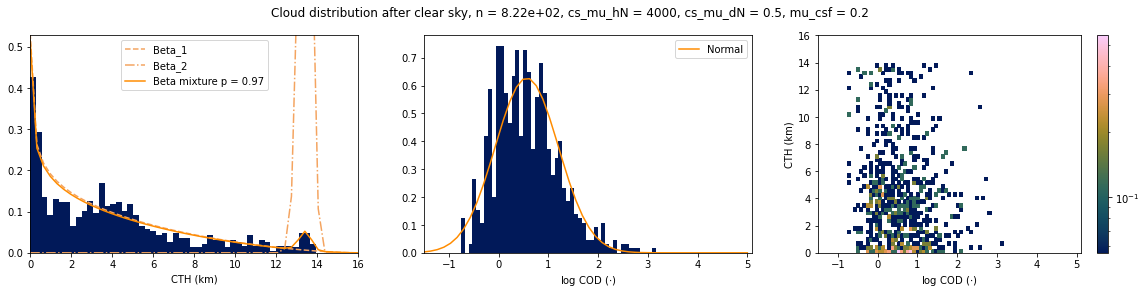

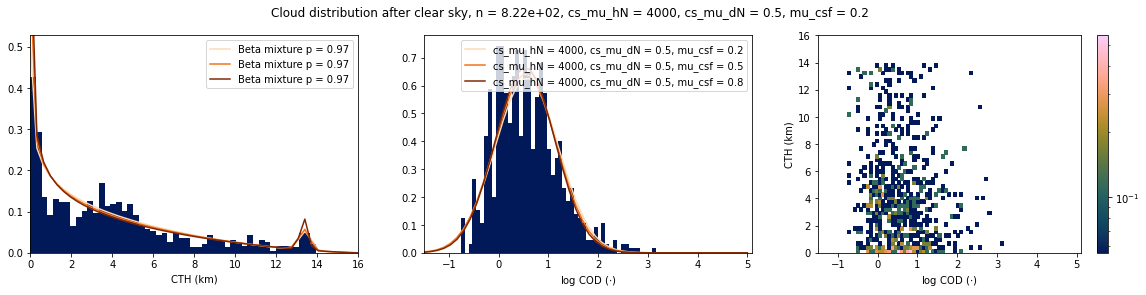

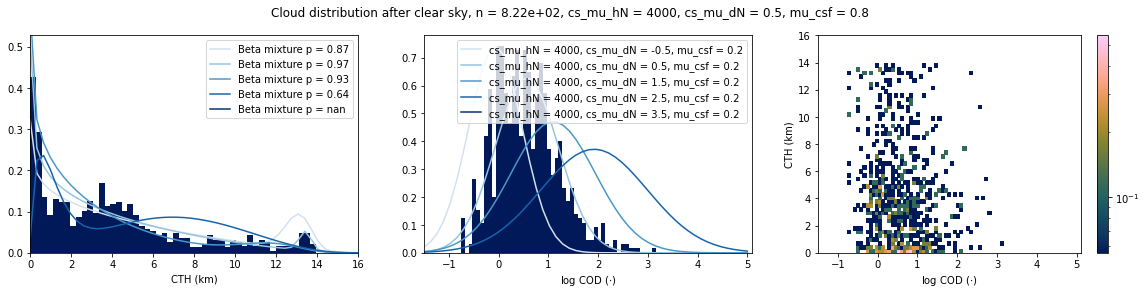

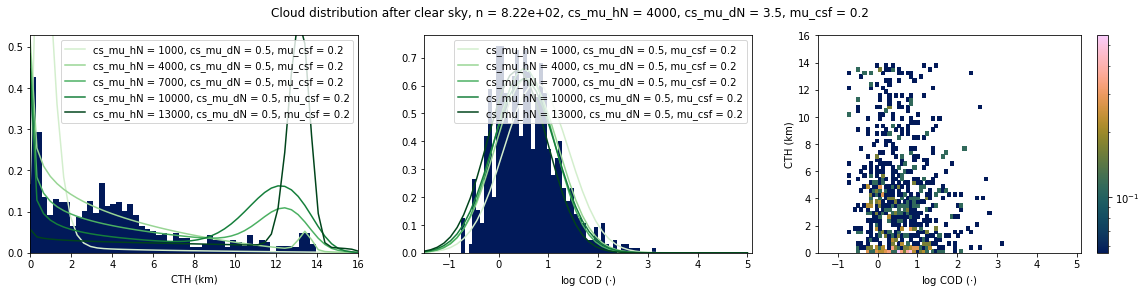

In [8]:
ind_hN, ind_dN, ind_csf = 1, 1, 0

cond = dict(cs_mu_hN = ds.cs_mu_hN[ind_hN],cs_mu_dN = ds.cs_mu_dN[ind_dN], mu_csf = mu_csf[ind_csf] )
cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
freq = ds.cs_freq.loc[cond].data
dedges = ds.cs_dedges.loc[cond].data
hedges = ds.cs_hedges.loc[cond].data

fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                      title = f'Cloud distribution after clear sky, n = {freq.sum().sum():.2e}, {cond_str}',
                     density = True)

mp.plotCTHBetaMix(ax[0], *ds.cs_param_cth_bm.loc[cond].loc[dict(est = 'coef')].data, param = 'mean_sum')
mp.plotCODNormal(ax[1], *ds.cs_param_cod.loc[cond])

ds
# theta = ds_theta.theta3
# mp.plotCTHBeta(ax[0], *theta[0:2])

cmap = cm.Oranges
color = cmap(np.linspace(.2,1, len(mu_csf)))

fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                      title = f'Cloud distribution after clear sky, n = {freq.sum().sum():.2e}, {cond_str}',
                     density = True)


for i, csf in zip(range(len(mu_csf)), mu_csf):
    cond = dict(cs_mu_hN = ds.cs_mu_hN[ind_hN], cs_mu_dN = ds.cs_mu_dN[ind_dN], mu_csf = csf )
    cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
    mp.plotCTHBetaMix(ax[0], *ds.cs_param_cth_bm.loc[cond].loc[dict(est = 'coef')].data, plotSubBeta = False, maincolor = color[i],
                            param = 'mean_sum'
                     )
    mp.plotCODNormal(ax[1], *ds.cs_param_cod.loc[cond], label = cond_str, color = color[i] )


fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                      title = f'Cloud distribution after clear sky, n = {freq.sum().sum():.2e}, {cond_str}',
                     density = True)
cmap = cm.Blues
color = cmap(np.linspace(.2,1, len(ds.cs_mu_dN)))
    
for i, dN in zip(range(len(ds.cs_mu_dN)), ds.cs_mu_dN):
    cond = dict(cs_mu_hN = ds.cs_mu_hN[ind_hN], cs_mu_dN = dN, mu_csf = mu_csf[ind_csf] )
    cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
    mp.plotCTHBetaMix(ax[0], *ds.cs_param_cth_bm.loc[cond].loc[dict(est = 'coef')].data, 
                      plotSubBeta = False,
                      maincolor = color[i],
                     param = 'mean_sum'
                     )
    mp.plotCODNormal(ax[1], *ds.cs_param_cod.loc[cond], label = cond_str, color = color[i] )

    
fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                      title = f'Cloud distribution after clear sky, n = {freq.sum().sum():.2e}, {cond_str}',
                     density = True)
cmap = cm.Greens
color = cmap(np.linspace(.2,1, len(ds.cs_mu_hN)))
    
for i, hN in zip(range(len(ds.cs_mu_hN)), ds.cs_mu_hN):
    cond = dict(cs_mu_hN = hN, cs_mu_dN = ds.cs_mu_dN[ind_dN], mu_csf = mu_csf[ind_csf] )
    cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
    mp.plotCTHBetaMix(ax[0], *ds.cs_param_cth_bm.loc[cond].loc[dict(est = 'coef')].data, mainlabel = cond_str,
                      plotSubBeta = False, maincolor = color[i],
                     param = 'mean_sum' 
                     )
    mp.plotCODNormal(ax[1], *ds.cs_param_cod.loc[cond], label = cond_str, color = color[i] )


    

# fig.savefig(loc_fig + 'expl_cs_cloud_distr_3.png')


# 4. Cloud to Cloud

In [30]:
ds.mu_dN

<xarray.DataArray 'mu_dN' (mu_dN: 5)>
array([-0.8, -0.4,  0. ,  0.4,  0.8])
Coordinates:
  * mu_dN    (mu_dN) float64 -0.8 -0.4 0.0 0.4 0.8

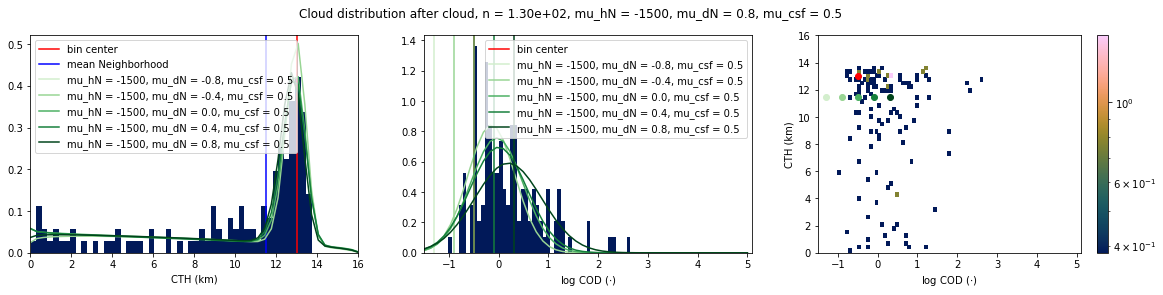

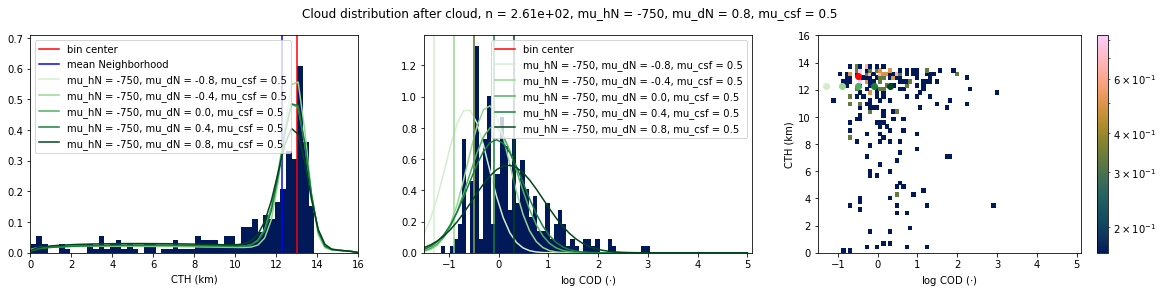

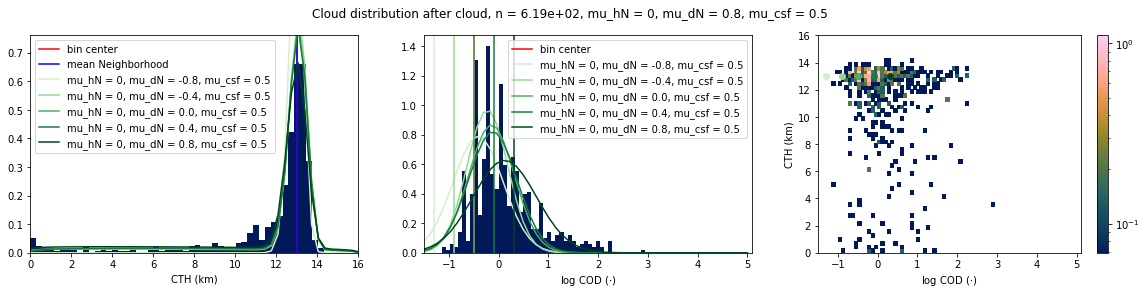

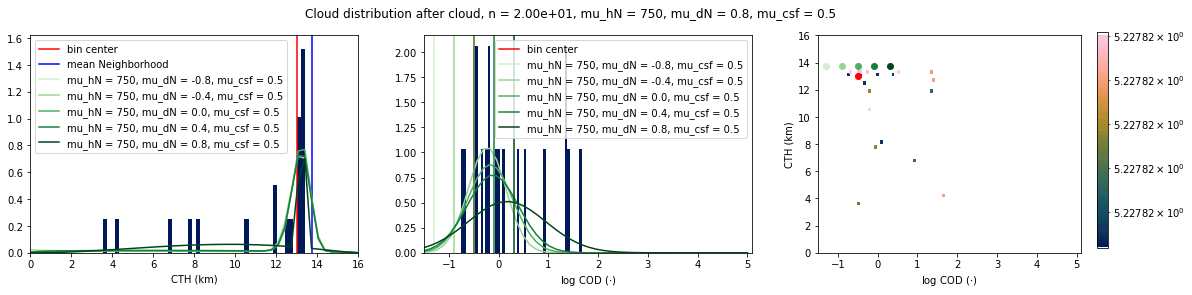

In [10]:
hlim = mp.hlim
dlim = mp.dlim

h, d = 13000, -.5
dic = dict(mu_h = h, mu_d = d)
ds_hd = ds.loc[dic]

   
for hN in ds.mu_hN:
    csf = ds.mu_csf[1]
    mu_dN = ds.mu_dN[2]
    cond = dict(mu_hN = hN, mu_dN = dN, mu_csf = csf)
    cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
    freq = ds_hd.freq.loc[cond].data
    dedges = ds_hd.dedges.loc[cond].data
    hedges = ds_hd.hedges.loc[cond].data
    if np.isnan(dedges).any():
        continue

    

#     df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
#     param = df_bin_fit.loc[(df_bin_fit.bincenter_h == h) & (df_bin_fit.bincenter_d == d)]
#     print(h,d)
    
#     fig , ax = mp.plot_distribution_next_cloud(df_bin, ML = False, density = True) # histograms cth, cod, joint
    fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution after cloud, n = {freq.sum().sum():.2e}, {cond_str}',
                         density = True)
    ax[0].axvline(h*1e-3, color = 'r', label = 'bin center')
    ax[0].axvline((h + hN)*1e-3, color = 'b', label = 'mean Neighborhood')
    ax[1].axvline(d, color = 'r', label = 'bin center')
    ax[2].plot(d, h*1e-3,'ro', label = 'bin center')


    
    for i, dN in zip(range(len(ds.mu_dN)), ds.mu_dN) :
   
    # bin centers

        ax[1].axvline((d + dN), color = color[i],
#                       label = 'mean Neighbourhood'
                     )
        ax[2].plot((d + dN), (h + hN)*1e-3,'o', color = color[i], label = 'mean Neighbourhood')

#     for i, csf in zip(range(len(ds.mu_csf)), ds.mu_csf) :
        cond = dict(mu_hN = hN, mu_dN = dN, mu_csf = csf )
        cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
        mp.plotCTHBetaMix(ax[0], *ds_hd.param_cth_bm.loc[cond].loc[dict(est = 'coef')].data, mainlabel = cond_str, plotSubBeta = False, maincolor = color[i], param = 'mean_sum')
        mp.plotCODNormal(ax[1], *ds_hd.param_cod.loc[cond], label = cond_str, color = color[i] )


        

    
# fig.savefig(loc_fig + f'expl_bins{idx}.png')


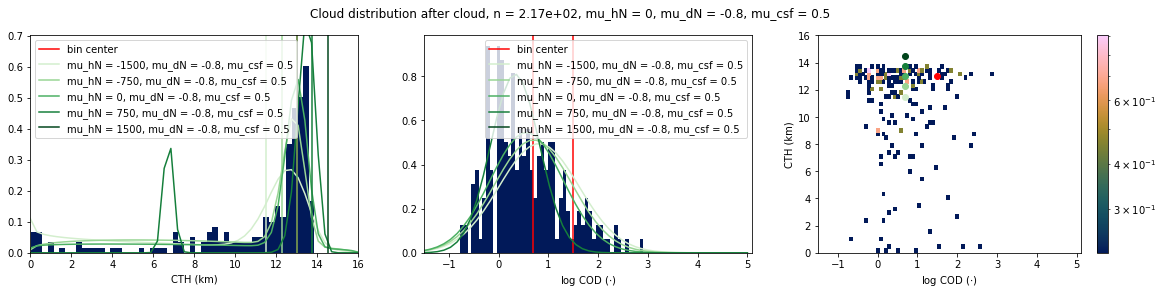

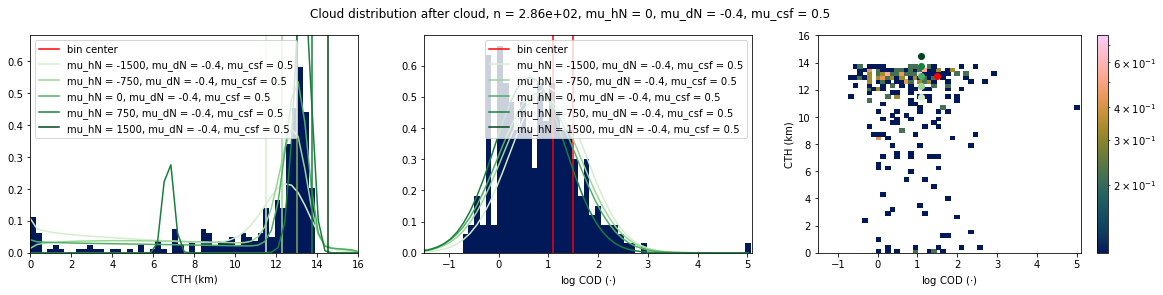

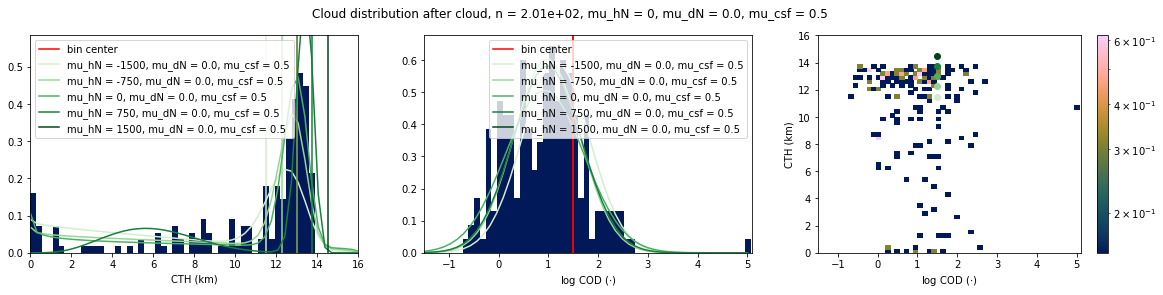

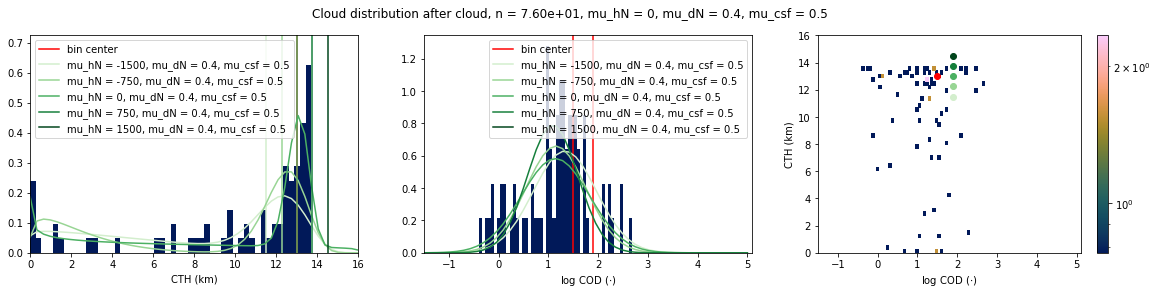

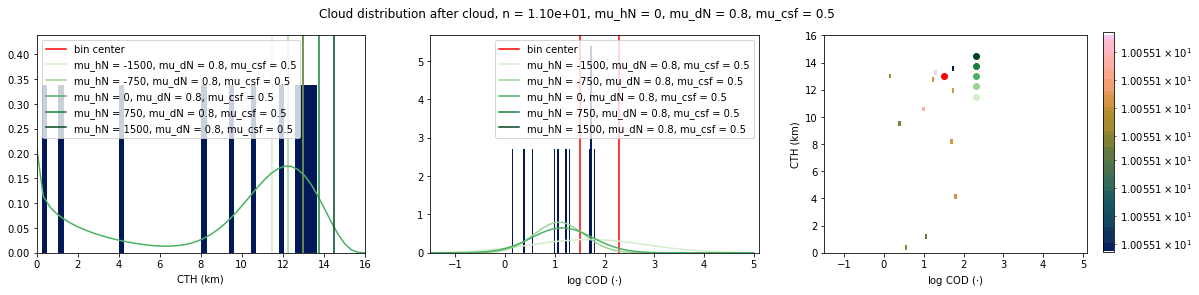

In [9]:
hlim = mp.hlim
dlim = mp.dlim

h, d = 13000, 1.5
dic = dict(mu_h = h, mu_d = d)
ds_hd = ds.loc[dic]

   
for dN in ds.mu_dN:
    csf = ds.mu_csf[1]
    hN = ds.mu_hN[2]
    cond = dict(mu_hN = hN, mu_dN = dN, mu_csf = csf)
    cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
    freq = ds_hd.freq.loc[cond].data
    dedges = ds_hd.dedges.loc[cond].data
    hedges = ds_hd.hedges.loc[cond].data
    if np.isnan(dedges).any():
        continue

    

#     df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
#     param = df_bin_fit.loc[(df_bin_fit.bincenter_h == h) & (df_bin_fit.bincenter_d == d)]
#     print(h,d)
    
#     fig , ax = mp.plot_distribution_next_cloud(df_bin, ML = False, density = True) # histograms cth, cod, joint
    fig, ax = mp.plotCloudHist_f(dedges, hedges, freq,
                          title = f'Cloud distribution after cloud, n = {freq.sum().sum():.2e}, {cond_str}',
                         density = True)
    ax[0].axvline(h*1e-3, color = 'r', label = 'bin center')
    ax[1].axvline(d, color = 'r', label = 'bin center')
    ax[2].plot(d, h*1e-3,'ro', label = 'bin center')
    ax[1].axvline((d + dN), color = 'r',
#                       label = 'mean Neighbourhood'
                 )


    
    for i, hN in zip(range(len(ds.mu_hN)), ds.mu_hN) :
   
    # bin centers
        ax[0].axvline((h + hN)*1e-3, color = color[i], 
#                       label = 'mean Neighborhood'
                     )

        ax[2].plot((d + dN), (h + hN)*1e-3,'o', color = color[i], label = 'mean Neighbourhood')


#     for i, csf in zip(range(len(ds.mu_csf)), ds.mu_csf) :
        cond = dict(mu_hN = hN, mu_dN = dN, mu_csf = csf )
        cond_str = ', '.join([f'{k} = {cond[k].data}' for k in cond])
        mp.plotCTHBetaMix(ax[0], *ds_hd.param_cth_bm.loc[cond].loc[dict(est = 'coef')].data, mainlabel = cond_str, plotSubBeta = False, maincolor = color[i], param = 'mean_sum')
        mp.plotCODNormal(ax[1], *ds_hd.param_cod.loc[cond], label = cond_str, color = color[i] )


        

    
# fig.savefig(loc_fig + f'expl_bins{idx}.png')


In [37]:
ds.param_cod.loc[dict(var_cod = 'mu')]

<xarray.DataArray 'param_cod' (mu_h: 3, mu_d: 3, mu_hN: 5, mu_dN: 5, mu_csf: 3)>
array([[[[[      nan, ...,       nan],
          ...,
          [      nan, ...,       nan]],

         ...,

         [[-0.526271, ...,       nan],
          ...,
          [ 0.393205, ...,  0.777969]]],


        ...,


        [[[      nan, ...,       nan],
          ...,
          [      nan, ...,       nan]],

         ...,

         [[ 2.48741 , ...,       nan],
          ...,
          [ 3.976991, ...,       nan]]]],



       ...,



       [[[[-0.185482, ...,       nan],
          ...,
          [ 0.261121, ..., -0.044931]],

         ...,

         [[      nan, ...,       nan],
          ...,
          [      nan, ...,       nan]]],


        ...,


        [[[ 2.659985, ...,       nan],
          ...,
          [ 4.059605, ...,       nan]],

         ...,

         [[      nan, ...,       nan],
          ...,
          [      nan, ...,       nan]]]]])
Coordinates:
  * mu_h     (mu_h) int64 1000 7000 13000
  * mu_d     (mu_d) float64 -0.5 1.5 3.5
  * mu_hN    (mu_hN) int64 -1500 -750 0 750 1500
  * mu_dN    (mu_dN) float64 -0.8 -0.4 0.0 0.4 0.8
  * mu_csf   (mu_csf) float64 0.2 0.5 0.8
    var_cod  <U2 'mu'

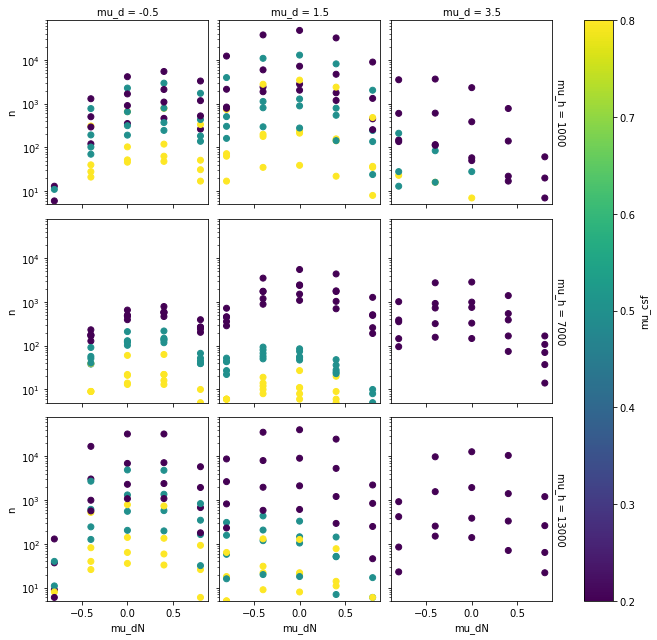

In [116]:
theta = ds.loc[dict(var_cod = 'mu')]
g = theta.plot.scatter(y = 'n', x = 'mu_dN', hue = 'mu_csf', col = 'mu_d', row = 'mu_h')
for ax in g.axes.flatten():
    ax.set_yscale('log')
    ax.set_ylim([5, 8e4])
# print('Influence of conditional parameters on n')

Influence of conditional parameters on mu.


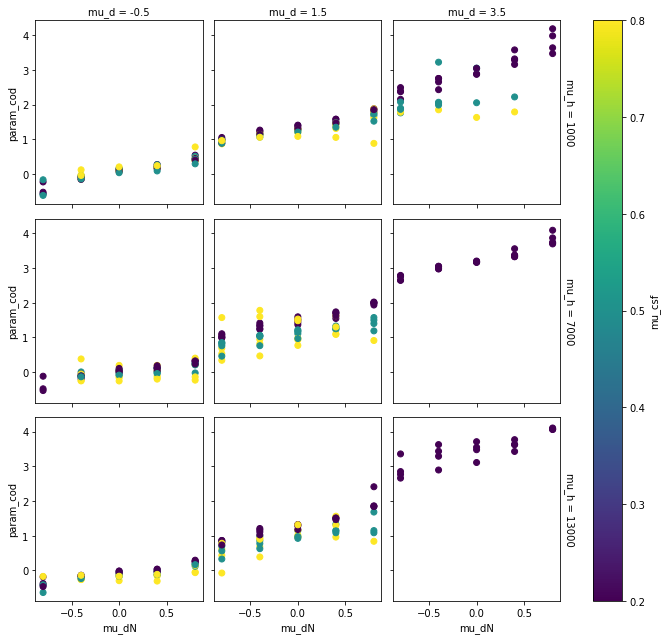

In [80]:
theta = ds.loc[dict(var_cod = 'mu')]
g = theta.plot.scatter(y = 'param_cod', x = 'mu_dN', hue = 'mu_csf', col = 'mu_d', row = 'mu_h')
print('Influence of conditional parameters on mu.')

Influence of conditional parameters on sigma.


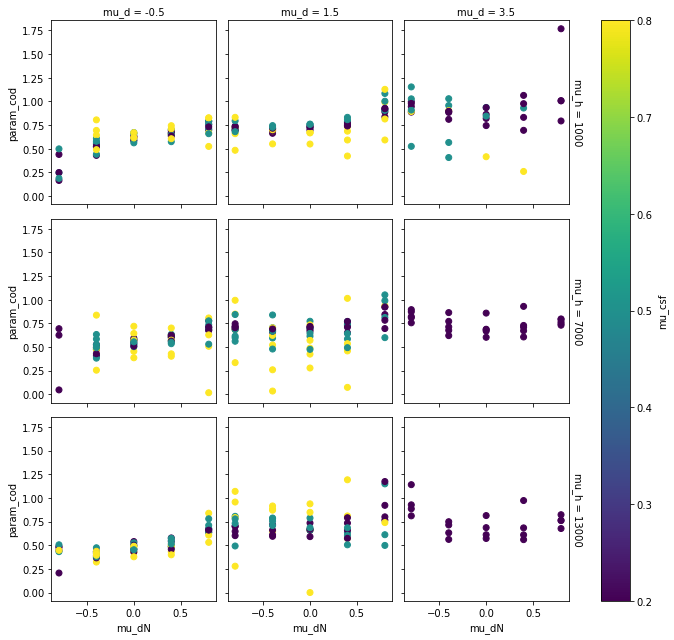

In [99]:
theta = ds.loc[dict(var_cod = 'sigma')]
g = theta.plot.scatter(y = 'param_cod', x = 'mu_dN', hue = 'mu_csf', col = 'mu_d', row = 'mu_h')
print('Influence of conditional parameters on sigma.')

In [123]:
ds.param_cth_bm

<xarray.DataArray 'param_cth_bm' (mu_h: 3, mu_d: 3, mu_hN: 5, mu_dN: 5, mu_csf: 3, est: 2, var_cth_bm: 5)>
array([[[[[[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]],



         ...,



         [[[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[1.442711e+00, ..., 7.553611e-01],
            [1.380145e-01, ..., 5.717354e-02]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]]],




        ...,




        [[[[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]],



         ...,



         [[[[1.278592e+00, ..., 9.280740e-01],
            [1.512445e-01, ..., 2.285797e-02]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]]]],





       ...,





       [[[[[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[8.104232e+01, ..., 5.734626e-01],
            [1.268607e+01, ..., 2.895160e-02]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]],



         ...,



         [[[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]]],




        ...,




        [[[[[1.087451e+02, ..., 5.392063e-01],
            [2.959163e+01, ..., 6.693599e-02]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[6.544316e+01, ..., 8.554852e-01],
            [2.851933e+01, ..., 1.258676e-01]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]],



         ...,



         [[[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]],


          ...,


          [[[         nan, ...,          nan],
            [         nan, ...,          nan]],

           ...,

           [[         nan, ...,          nan],
            [         nan, ...,          nan]]]]]]])
Coordinates:
  * mu_h        (mu_h) int64 1000 7000 13000
  * mu_d        (mu_d) float64 -0.5 1.5 3.5
  * mu_hN       (mu_hN) int64 -1500 -750 0 750 1500
  * mu_dN       (mu_dN) float64 -0.8 -0.4 0.0 0.4 0.8
  * mu_csf      (mu_csf) float

Influence of conditional parameters on sigma.


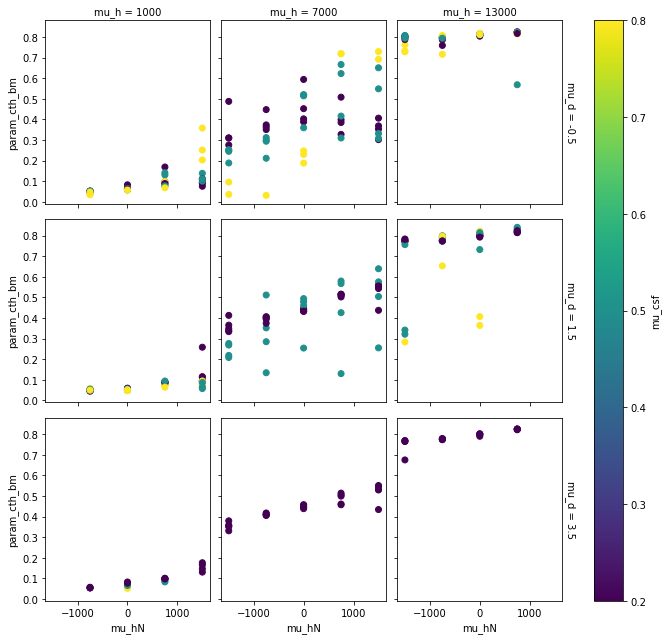

In [13]:
theta = ds.loc[dict(var_cth_bm = 'mu1', est = 'coef' )]

g = theta.plot.scatter(y = 'param_cth_bm', x = 'mu_hN', hue = 'mu_csf', col = 'mu_h', row = 'mu_d')
print('Influence of conditional parameters on mu1.')

Influence of conditional parameters on mu1.


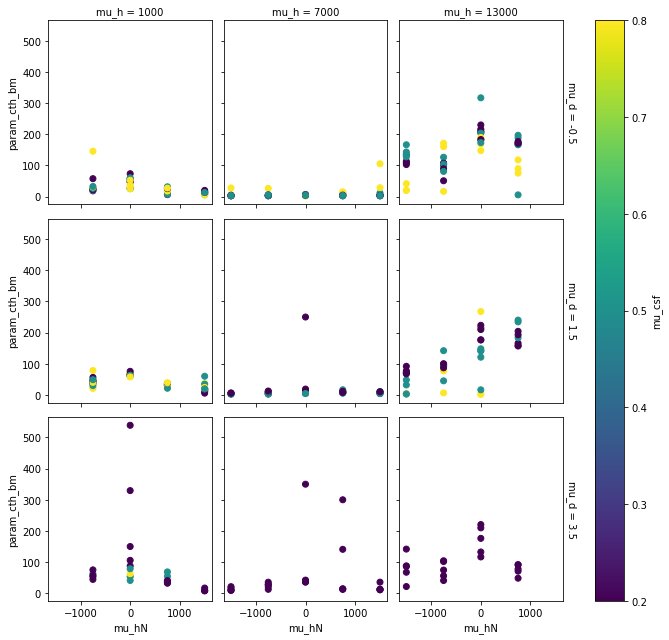

In [14]:
theta = ds.loc[dict(var_cth_bm = 'nu1', est = 'coef' )]

g = theta.plot.scatter(y = 'param_cth_bm', x = 'mu_hN', hue = 'mu_csf', col = 'mu_h', row = 'mu_d')
print('Influence of conditional parameters on mu1.')

mu_h
mu_d
mu_hN
mu_dN
mu_csf


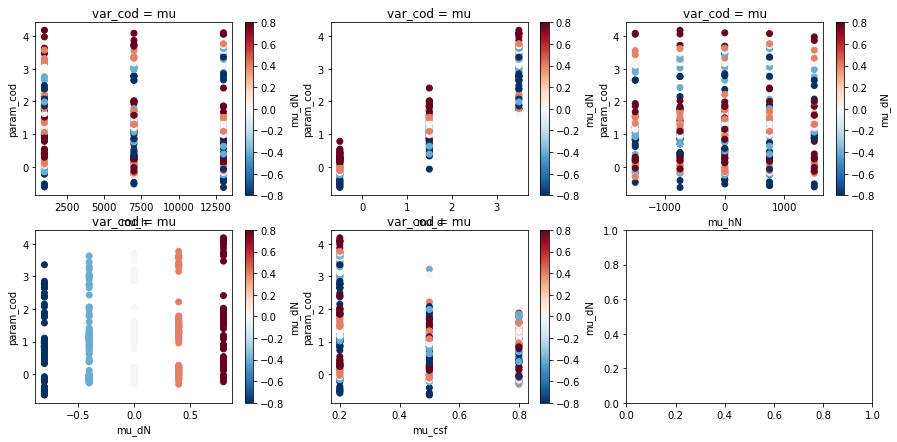

In [127]:
theta = ds.loc[dict(var_cod = 'mu')]
dims = theta.param_cod.dims
fig, ax = plt.subplots(2, 3, figsize =(15, 7))
axes = ax.flatten()
for i, k in zip(range(len(dims)), dims):
    print(k)
    theta.plot.scatter(y = 'param_cod', x = k, ax = axes[i], hue = 'mu_dN')
# theta.plot.scatter(x = 'mu_d', y = 'param_cod', hue = 'mu_dN', alpha = .4)

In [17]:
i = 0
def AIC(k, L):
    ### L maximized log likelihood
    return 2 * k - 2 * L

def BIC(k, L, n):
    ### L maximized log likelihood
    return k * np.log(n) - 2 * L

def MoM_sb(x):
    m1 = x.mean()
    m2 = (x**2).mean()
    alpha = m1 * (m1 - m2) /(m2 - m1**2)
    beta = (m1/m2 - 1) * (alpha +1)
    return alpha , beta

mom = np.zeros((len(df_bin_fit),2))

for idx, (h,d) in df_bin_fit[['bincenter_h', 'bincenter_d']].iterrows():
    df_bin = df.loc[(df.bincenter_h == h) & (df.bincenter_d == d)]
    
    mom[idx,:] = MoM_sb(ml.CTHtoUnitInt(df_bin.h_t_next))
#     print(mom)
    
    
for fit_mb, fit_sb in zip(fits, fits_sb) :
#     print(fit.summary())
    print(i)
    print(fit_mb.llf, fit_sb.llf)
    print(AIC(5, fit_mb.llf), AIC(2, fit_sb.llf))
    print(BIC(5, fit_mb.llf, fit_mb.nobs), BIC(2, fit_sb.llf, fit_sb.nobs))
    print(fit_sb.params)
    print(fit_sb.params - 2*fit_sb.bse, 'lower')
    print(fit_sb.params + 2*fit_sb.bse, 'upper')
    print(mom[i,:])
# dir(fit)
    
    i+=1



In [19]:
fit.summary()

NameError: name 'fit' is not defined

## local behaviour parameters

## cod

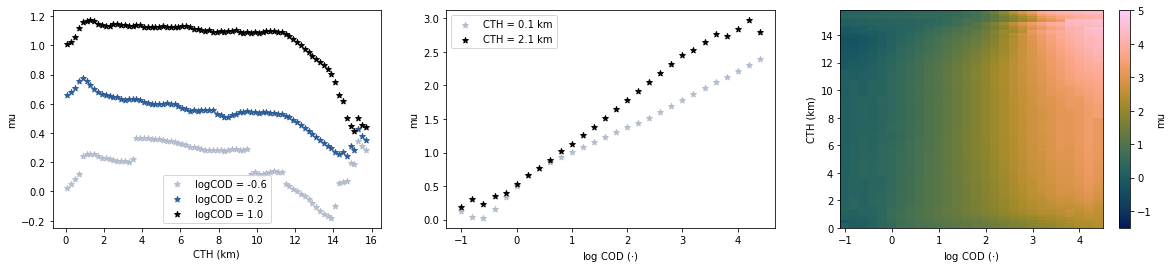

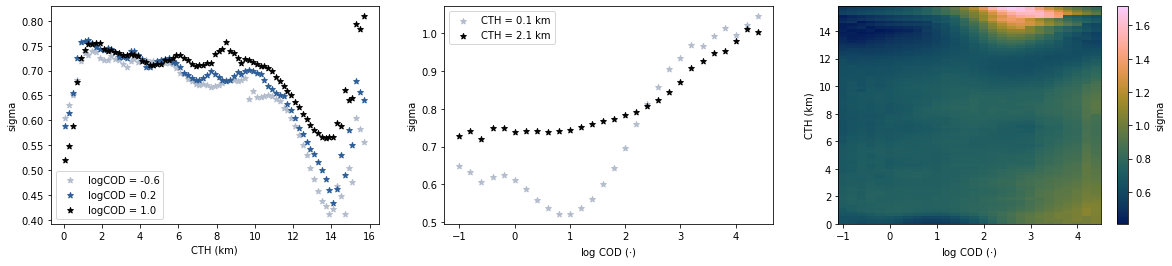

In [25]:

fig, ax = mp.plotLocalParam(ds_local.mu, vmin = -1.5, vmax = 5)
fig.savefig('../fig/model1/expl_local_mu.png')

fig, ax = mp.plotLocalParam(ds_local.sigma)#, vmax = 1.2)
fig.savefig('../fig/model1/expl_local_sigma.png')

## CTH

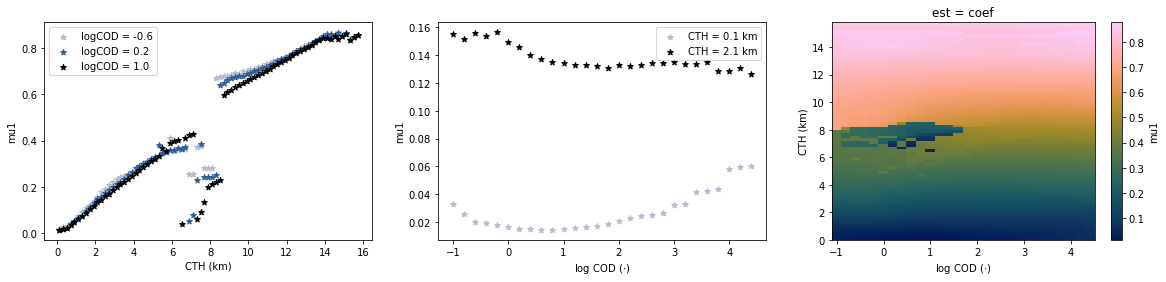

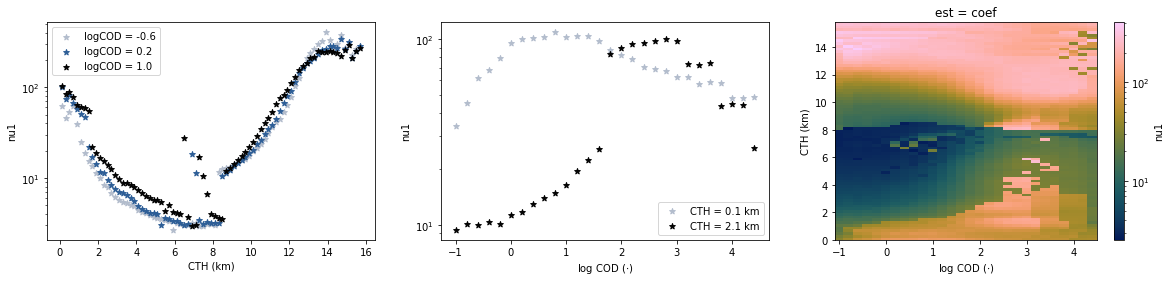

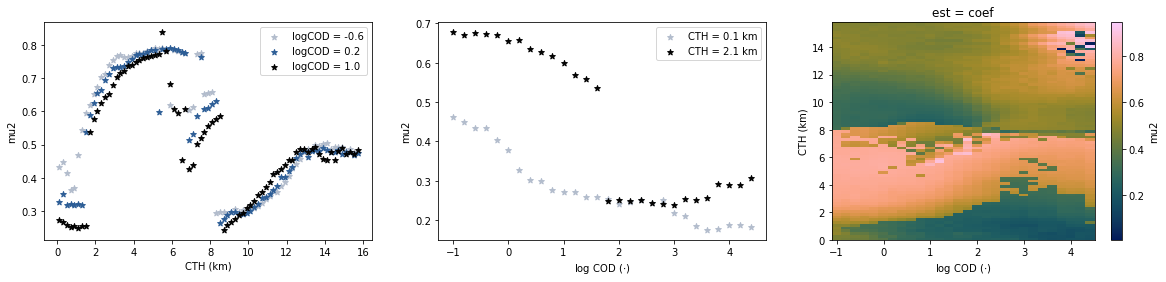

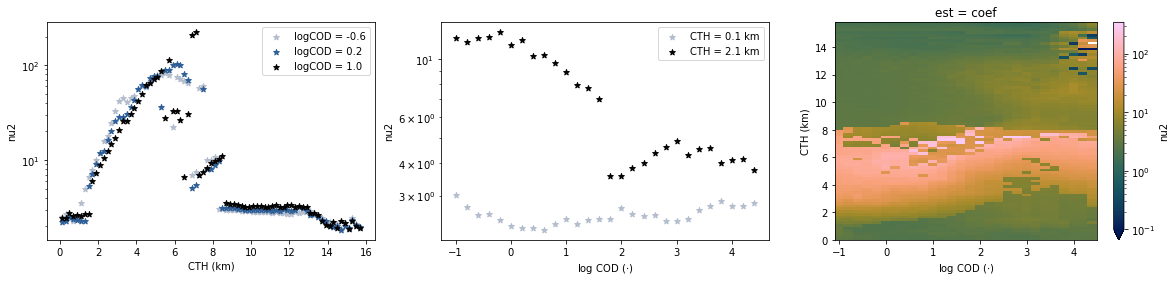

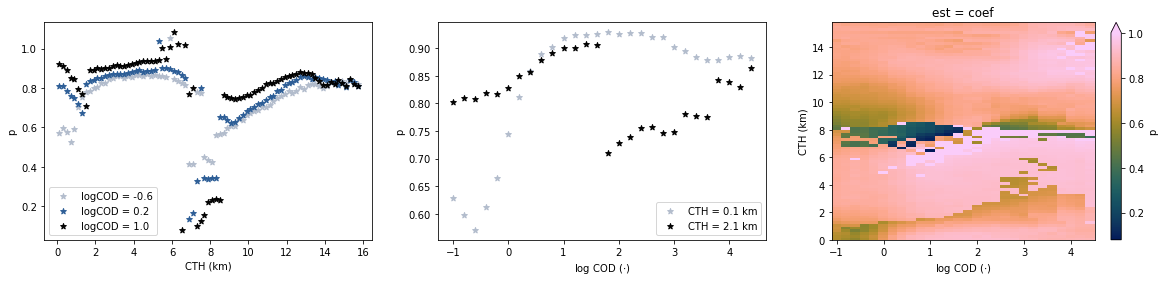

In [21]:
mu1 = me.meanBeta(ds_local.alpha1, ds_local.beta1).rename('mu1')
nu1 = (ds_local.alpha1 + ds_local.beta1).rename('nu1')
mu2 = me.meanBeta(ds_local.alpha2, ds_local.beta2).rename('mu2')
nu2 = (ds_local.alpha2 + ds_local.beta2).rename('nu2')

fig, ax = mp.plotLocalParam(mu1.loc[:,:, 'coef'])
fig.savefig(loc_fig + 'expl_local_mu1.png')
fig, ax = mp.plotLocalParam(nu1.loc[:,:, 'coef'], logscale = True)
fig.savefig(loc_fig + 'expl_local_nu1.png')
fig, ax = mp.plotLocalParam(mu2.loc[:,:, 'coef'])
fig.savefig(loc_fig + 'expl_local_mu2.png')

nu2 = nu2.where(nu2 < 1e3)
fig, ax = mp.plotLocalParam(nu2.loc[:,:, 'coef'], logscale = True, vmin = .1)
fig.savefig(loc_fig + 'expl_local_nu2.png')
fig, ax = mp.plotLocalParam(ds_local.p.loc[:,:, 'coef'], vmax = 1)
fig.savefig(loc_fig + 'expl_local_p.png')


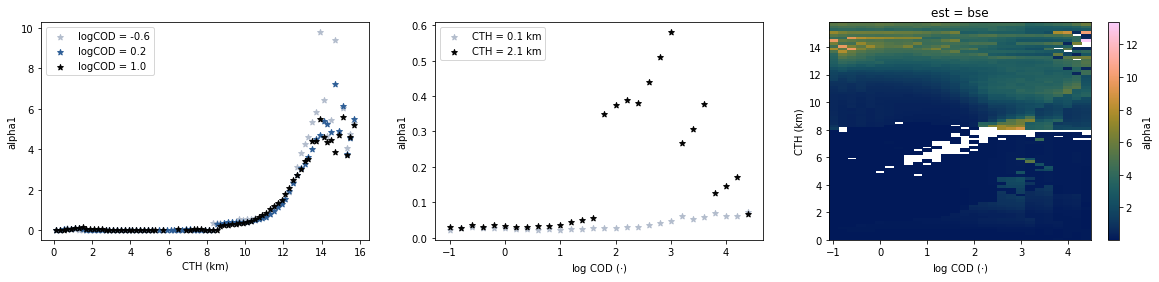

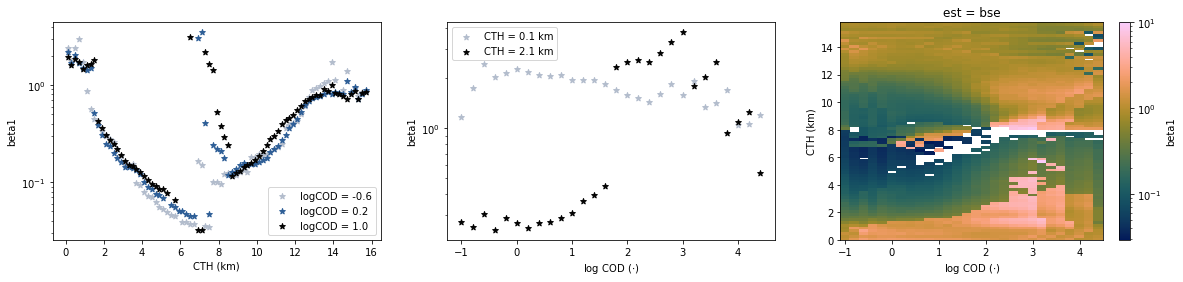

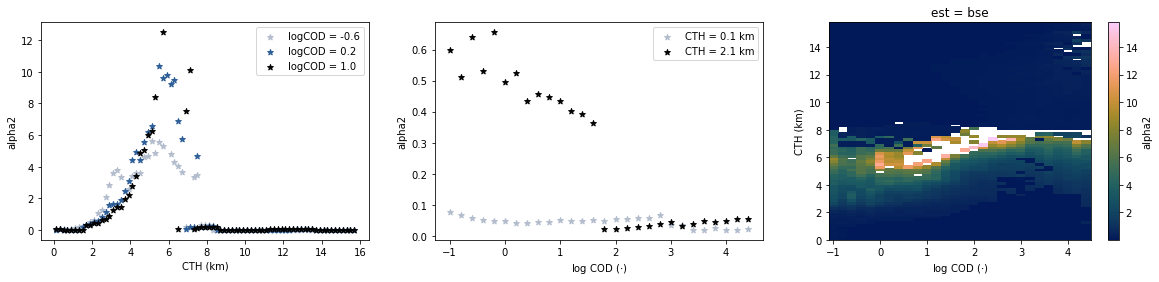

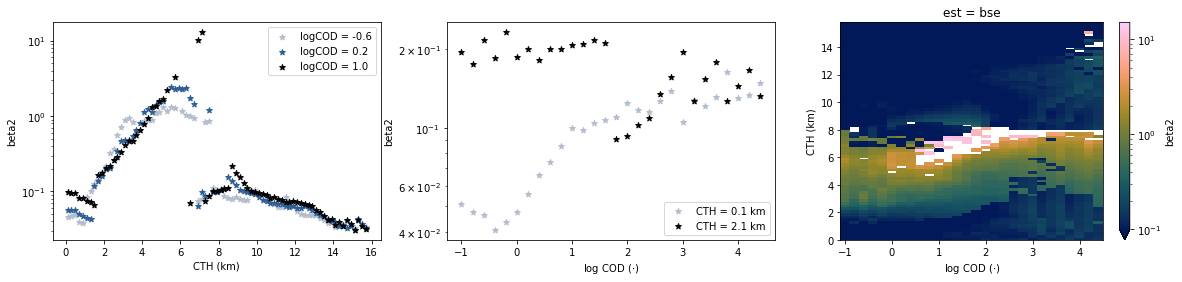

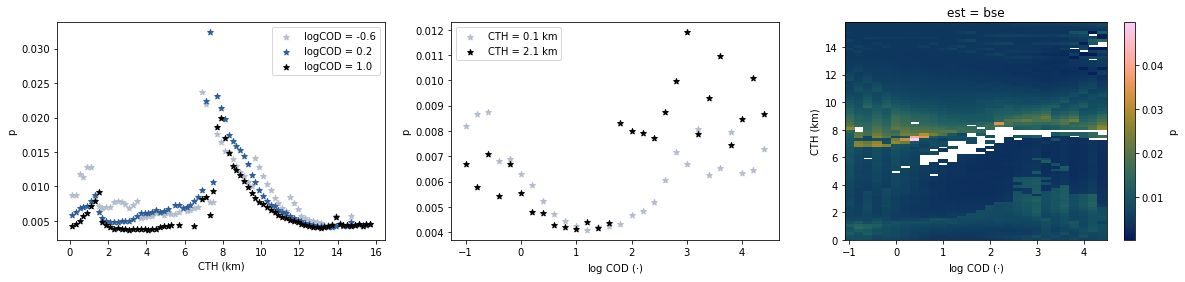

In [22]:
fig, ax = mp.plotLocalParam(ds_local.alpha1.loc[:,:, 'bse'])
fig.savefig(loc_fig + 'expl_local_mu1.png')
fig, ax = mp.plotLocalParam(ds_local.beta1.loc[:,:, 'bse'], logscale = True)
fig.savefig(loc_fig + 'expl_local_nu1.png')
fig, ax = mp.plotLocalParam(ds_local.alpha2.loc[:,:, 'bse'])
fig.savefig(loc_fig + 'expl_local_mu2.png')

nu2 = nu2.where(nu2 < 1e3)
fig, ax = mp.plotLocalParam(ds_local.beta2.loc[:,:, 'bse'], logscale = True, vmin = .1)
fig.savefig(loc_fig + 'expl_local_nu2.png')
fig, ax = mp.plotLocalParam(ds_local.p.loc[:,:, 'bse'])
fig.savefig(loc_fig + 'expl_local_p.png')


### Test Statistics



In [23]:
ds_local

<xarray.Dataset>
Dimensions:  (est: 2, method: 2, mu_d: 28, mu_h: 79)
Coordinates:
  * mu_h     (mu_h) float64 100.0 300.0 500.0 ... 1.53e+04 1.55e+04 1.57e+04
  * mu_d     (mu_d) float64 -1.0 -0.8 -0.6 -0.4 -0.2 ... 3.6 3.8 4.0 4.2 4.4
  * method   (method) object 'ML' 'MoM'
  * est      (est) object 'coef' 'bse'
Data variables: (12/26)
    p_cs     (mu_h, mu_d) float64 0.2162 0.236 0.2407 ... 0.002149 0.001235
    n_c      (mu_h, mu_d) float64 1.758e+04 1.102e+04 ... 7.446e+03 7.286e+03
    dH       (mu_h, mu_d) float64 900.0 600.0 400.0 ... 2.025e+03 2.025e+03
    dD       (mu_h, mu_d) float64 0.9 0.6 0.4 0.4 ... 2.025 2.025 2.025 2.025
    mu       (mu_h, mu_d) float64 0.1284 0.04318 0.02573 ... 4.239 4.302 4.347
    sigma    (mu_h, mu_d) float64 0.6472 0.6334 0.6048 ... 0.9475 0.8635 0.7991
    ...       ...
    AIC_b    (mu_h, mu_d, method) float64 -1.656e+04 nan ... -2.147e+04 nan
    BIC_b    (mu_h, mu_d, method) float64 -1.654e+04 nan ... -2.145e+04 nan
    KS_b     (mu_h, mu_d, method) float64 0.1673 0.2086 0.1765 ... 0.1689 0.165
    CM_b     (mu_h, mu_d, method) float64 107.4 132.7 69.26 ... 94.09 81.46
    AD_b     (mu_h, mu_d, method) float64 541.1 800.0 350.4 ... 509.6 439.3
    conv_b   (mu_h, mu_d, method) float64 1.0 nan 1.0 nan ... 1.0 nan 1.0 nan
Attributes:
    dh:       200
    dd:       0.2
    p_cscs:   0.7308294268298162

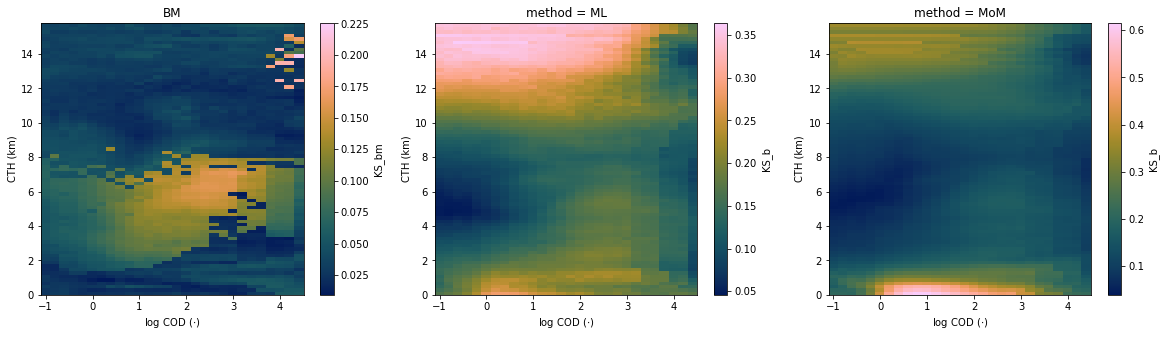

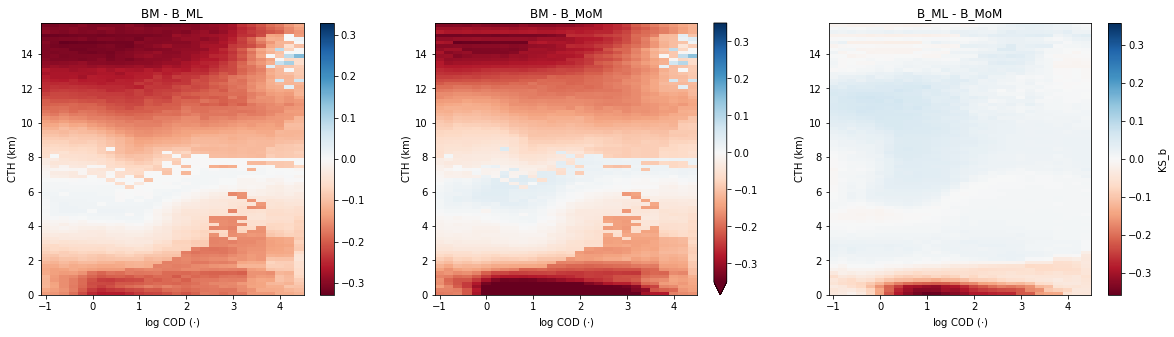

In [35]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.KS_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.KS_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.KS_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.KS_bm - ds_local.KS_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.KS_bm - ds_local.KS_b.loc[:,:, 'MoM'], cmap = cm.RdBu, vmin = -.35)
mp.plotLocalParam2d(ax[2], ds_local.KS_b.loc[:,:, 'ML'] - ds_local.KS_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

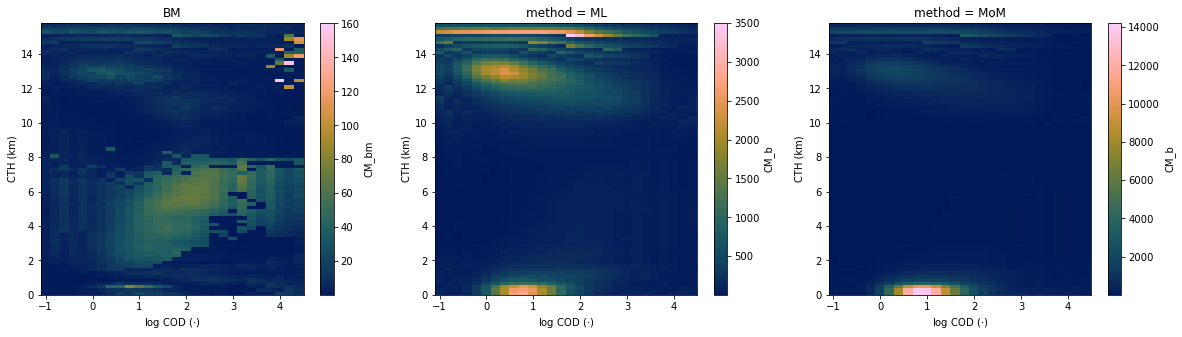

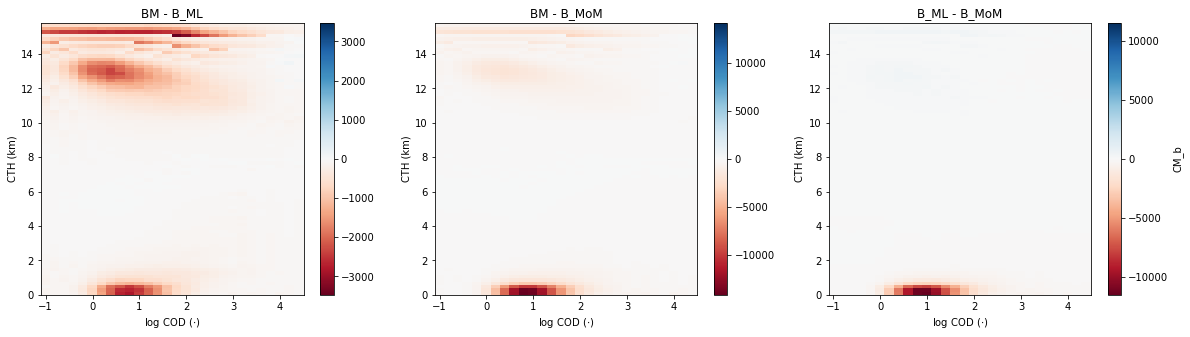

In [31]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.CM_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.CM_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.CM_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.CM_bm - ds_local.CM_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.CM_bm - ds_local.CM_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
mp.plotLocalParam2d(ax[2], ds_local.CM_b.loc[:,:, 'ML'] - ds_local.CM_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

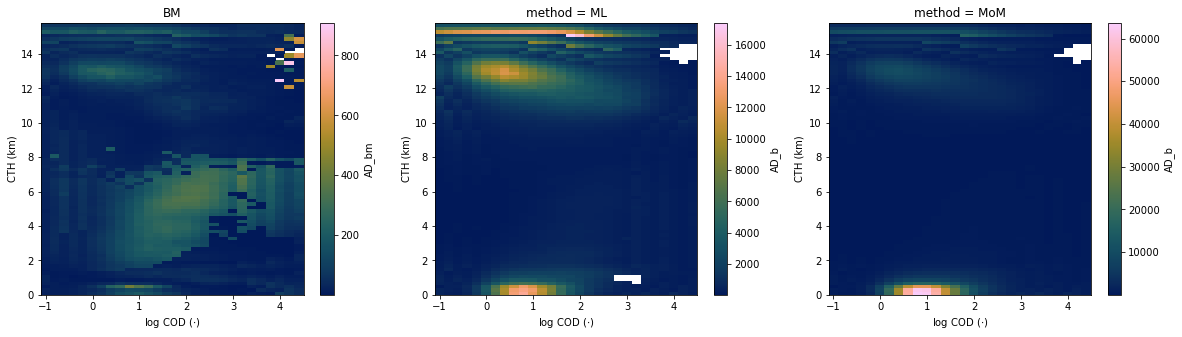

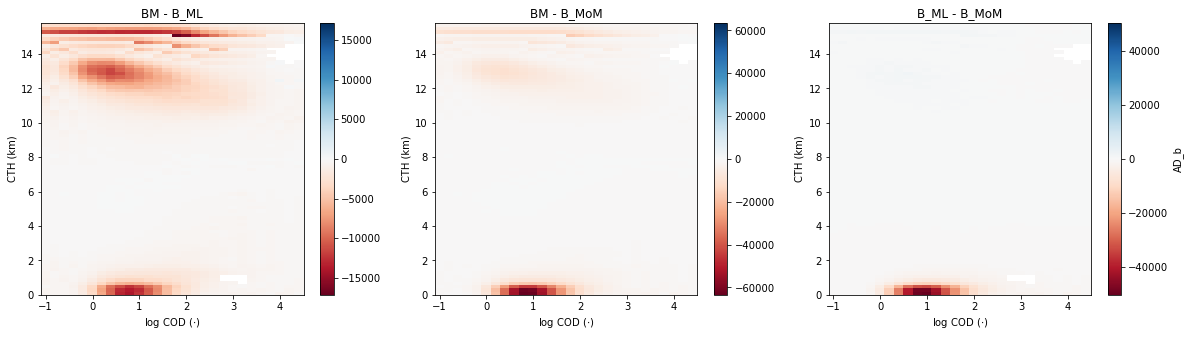

In [32]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.AD_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.AD_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.AD_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.AD_bm - ds_local.AD_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.AD_bm - ds_local.AD_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
mp.plotLocalParam2d(ax[2], ds_local.AD_b.loc[:,:, 'ML'] - ds_local.AD_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

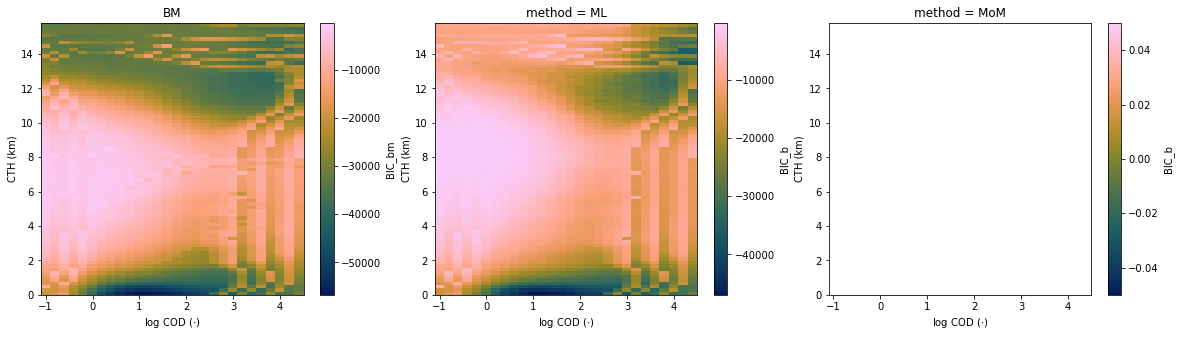

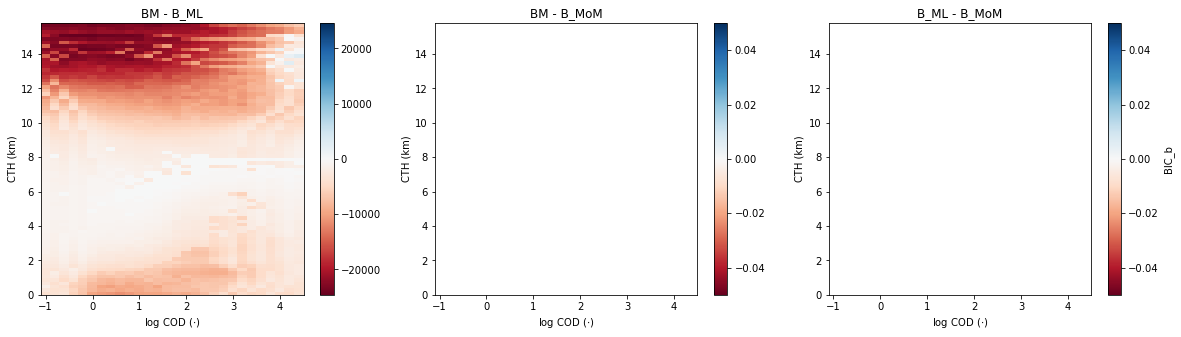

In [37]:
fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.BIC_bm)
ax[0].set_title('BM')
mp.plotLocalParam2d(ax[1], ds_local.BIC_b.loc[:,:, 'ML'])
mp.plotLocalParam2d(ax[2], ds_local.BIC_b.loc[:,:, 'MoM'])
plt.show()

fig, ax = plt.subplots(1,3, figsize = (20, 5))
mp.plotLocalParam2d(ax[0], ds_local.BIC_bm - ds_local.BIC_b.loc[:,:, 'ML'], cmap = cm.RdBu)
ax[0].set_title('BM - B_ML')
mp.plotLocalParam2d(ax[1], ds_local.BIC_bm - ds_local.BIC_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
mp.plotLocalParam2d(ax[2], ds_local.BIC_b.loc[:,:, 'ML'] - ds_local.BIC_b.loc[:,:, 'MoM'], cmap = cm.RdBu)
ax[1].set_title('BM - B_MoM')
ax[2].set_title('B_ML - B_MoM')

plt.show()

## clear sky to cloud

## cloud to clear sky